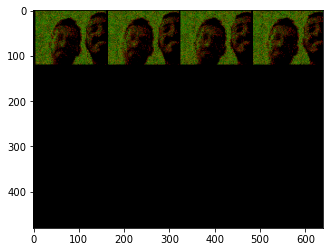

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import Overlay, MMIO
from PIL import Image

# Load the overlay
overlay = Overlay("./design_1.bit")

# Access the BRAM
bram_addr = 0x00A0000000
bram_size = 640 * 480 * 3 // 2  # 640x480 image with RGB444 format (12 bits per pixel, 1.5 bytes per pixel)
bram_mmio = MMIO(bram_addr, bram_size)

# Define the chunk size (in bytes)
chunk_size = 4
# Calculate the number of chunks needed
num_chunks = bram_size // chunk_size

# Initialize an empty list to store the data chunks
data_chunks = bytearray()

# Read the data in chunks
for i in range(num_chunks):
    chunk = bram_mmio.read(i * chunk_size, chunk_size)
    data_chunks.extend(chunk.to_bytes(chunk_size, 'little'))

# Convert the bytearray to a bytes object
data = bytes(data_chunks)

# Convert data to a numpy array of uint8
image_data = np.frombuffer(data, dtype=np.uint8)

# Initialize an array for the final image (3 channels for RGB)
final_image = np.zeros((480, 640, 3), dtype=np.uint8)

# Iterate through the image data and unpack RGB444 into RGB888 format for display
index = 0
for i in range(480):
    for j in range(640):
        if index + 1 < len(image_data):
            byte1 = image_data[index]
            byte2 = image_data[index + 1]

            r = (byte1 & 0xF0) >> 4
            g = (byte1 & 0x0F)
            b = (byte2 & 0xF0) >> 4

            # Scale the RGB444 values to RGB888
            final_image[i, j, 0] = (r << 4) | r  # Red
            final_image[i, j, 1] = (g << 4) | g  # Green
            final_image[i, j, 2] = (b << 4) | b  # Blue

            index += 2

# Display the image
plt.imshow(final_image)
plt.show()

# Save the image using PIL
image = Image.fromarray(final_image)
image.save("./captured_image.png")
